# Steps:
### 1. Take client name and legal entity name as input
### 2. Load relevant rows from dataset
### 3. Test stationarity of series using Dickey-Fuller Test, KPSS Test and Graphs
### 4. Convert non stationary series to stationary series if required
### 5. Apply ARIMA model

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

C:\Users\divya\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

### Take user input and load data

In [3]:
client = str(input("Enter Client Name : "))

Enter Client Name : jpmchase


In [4]:
le = str(input("Enter Legal Entity (eg. CitiBank Pune) : "))

Enter Legal Entity (eg. CitiBank Pune) : citibanknanewyork


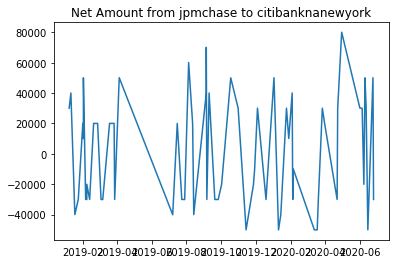

In [5]:
df = pd.read_csv(r'processed_data.csv', parse_dates = ['Payment Date'], index_col = 'Payment Date')
ts = df[(df['Client Name'] == client) & (df['Legal Entity'] == le)]['Paid Amount']
plt.title(f'Net Amount from {client} to {le}')
plt.plot(ts)
plt.show()

Text(0.5,1,'Moving Average of the data to show the trend')

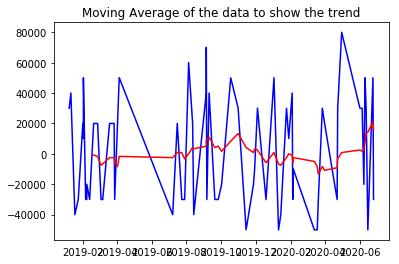

In [6]:
# Moving Average to show the trend

rolmean = ts.rolling(window=12,center=False).mean()
orig = plt.plot(ts.index.to_pydatetime(), ts.values, color='blue',label='Original')
mean = plt.plot(rolmean.index.to_pydatetime(), rolmean.values, color='red', label='Rolling Mean')
plt.title('Moving Average of the data to show the trend')

### Test stationarity

C:\Users\divya\Anaconda3\lib\site-packages\pandas\core\series.py:2993: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


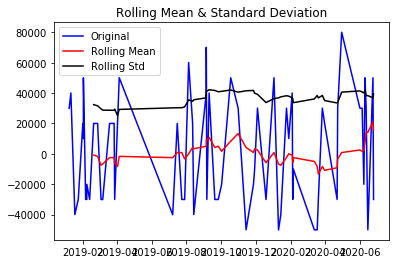

In [7]:
#Test stationarity using graphs
def test_stationarity(timeseries):
    
    timeseries.dropna(inplace = True)
    #print(len(timeseries))
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

test_stationarity(ts)

In [8]:
#Perform Dickey-Fuller test:
def df_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    pval = dfoutput['p-value']
    print(f'Result: The series is {"not " if pval > 0.05 else ""}stationary')
    
df_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                -8.484409e+00
p-value                        1.365566e-13
#Lags Used                     0.000000e+00
Number of Observations Used    6.400000e+01
Critical Value (1%)           -3.536928e+00
Critical Value (5%)           -2.907887e+00
Critical Value (10%)          -2.591493e+00
dtype: float64
Result: The series is stationary


In [9]:
# Perform KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')



In [10]:
kpss_test(ts)

KPSS Statistic: 0.1052835622602835
p-value: 0.1
num lags: 11
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\divya\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [11]:
kpss_test(ts, regression='ct')

KPSS Statistic: 0.08384827617982092
p-value: 0.1
num lags: 11
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The series is stationary


C:\Users\divya\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [12]:
'''
Result:
if a series is stationary according to the KPSS test by setting regression='ct' 
and is not stationary according to the ADF test, 
it means the series is stationary around a deterministic trend
'''

"\nResult:\nif a series is stationary according to the KPSS test by setting regression='ct' \nand is not stationary according to the ADF test, \nit means the series is stationary around a deterministic trend\n"

### Log transform and differencing

In [13]:
#deal with negative values by adding large positive constant
ts_log = np.log(ts + 100000)
len(ts_log)

65

In [14]:
ts_log.dropna(inplace=True)
len(ts_log)

65

In [15]:
# Applying differencing 
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

In [16]:
df_test(ts_log_diff)
#much lesser p-val

Results of Dickey-Fuller Test:
Test Statistic                -5.857661e+00
p-value                        3.469422e-07
#Lags Used                     5.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64
Result: The series is stationary


In [17]:
#kpss_test(ts_log_diff, regression='ct')

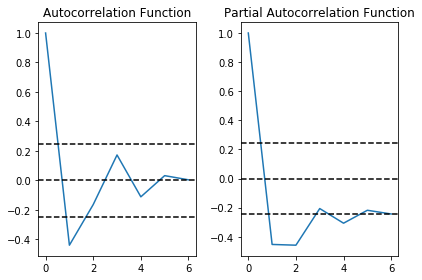

In [18]:
#ACF and PACF plots

lag_acf = acf(ts_log_diff, nlags=6)
lag_pacf = pacf(ts_log_diff, nlags=6, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='black')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='black')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### ARIMA Model

In [19]:
series = ts_log - np.log(100000)
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1, 1, 0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


C:\Users\divya\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\divya\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\divya\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=0.086658, expected=-0.694949
predicted=-0.206795, expected=-0.512093
predicted=-0.621231, expected=0.262618
predicted=-0.074353, expected=0.096028
predicted=0.160674, expected=0.336801
predicted=0.235834, expected=-0.357061
predicted=-0.073907, expected=-0.105816
predicted=-0.226845, expected=-0.694688
predicted=-0.462532, expected=-0.693627
predicted=-0.722320, expected=-0.357247
predicted=-0.521264, expected=0.262718
predicted=0.005398, expected=0.182838
predicted=0.212629, expected=-0.357375
predicted=-0.156169, expected=0.262856
predicted=0.003022, expected=0.587920
predicted=0.467374, expected=0.263079
predicted=0.392024, expected=0.262418
predicted=0.262176, expected=-0.223919
predicted=-0.043533, expected=0.405625
predicted=0.150958, expected=0.263026
predicted=0.320267, expected=-0.693507
predicted=-0.337287, expected=0.405912
predicted=-0.070492, expected=-0.357289
Test MSE: 0.259


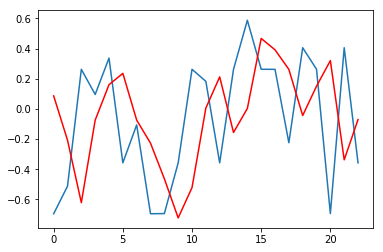

In [20]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()